# 1 Part

In [1]:
from melbanks import LogMelFilterBanks
import torch
import torchaudio

In [2]:
signal, sr = torchaudio.load("/home/darinka/Downloads/My Little Black Angel Death In June.wav")

In [3]:
melspec = torchaudio.transforms.MelSpectrogram(
    hop_length=160,
    n_mels=80
)(signal)
logmelbanks = LogMelFilterBanks()(signal)
log_melspec = torch.log(melspec + 1e-6)

assert log_melspec.shape == logmelbanks.shape
assert torch.allclose(log_melspec, logmelbanks)

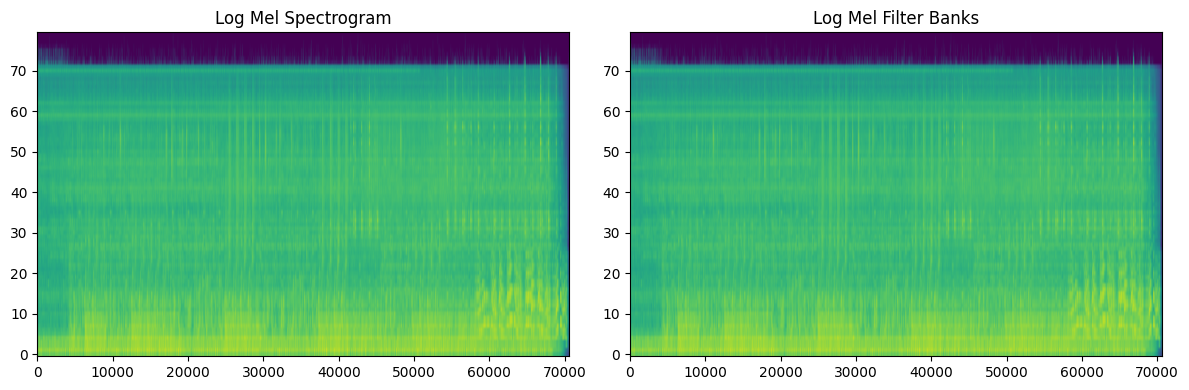

In [4]:
import matplotlib.pyplot as plt

log_melspec_np = log_melspec[0].cpu().numpy()
logmelbanks_np = logmelbanks[0].cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].imshow(log_melspec_np, origin="lower", aspect="auto")
axs[0].set_title("Log Mel Spectrogram")

axs[1].imshow(logmelbanks_np, origin="lower", aspect="auto")
axs[1].set_title("Log Mel Filter Banks")

plt.tight_layout()
plt.show()

# 2 Part

In [5]:
from cnn import BinarySpeechCommands, SpeechCommandBinaryClassifier, collate_fn
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from lightning.pytorch.loggers import WandbLogger

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
train_dataset = BinarySpeechCommands(subset="training")
val_dataset = BinarySpeechCommands(subset="validation")
test_dataset = BinarySpeechCommands(subset="testing")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [7]:
model = SpeechCommandBinaryClassifier(lr=1e-3)
_ = model.compute_flops(input_size=(1, train_dataset[0][0].shape[0]))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN FLOPs: 1782720.0   MACs: 891360.0   Params: 10898.0 



In [8]:
wandb_logger = WandbLogger(
    project="Speech_homework",
    log_model="all"
)
trainer = pl.Trainer(max_epochs=10, logger=wandb_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: darinka to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | LogMelFilterBanks | 0      | train
1 | cnn               | CNN               | 10.9 K | train
2 | criterion         | CrossEntropyLoss  | 0      | train
----------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 250/250 [00:13<00:00, 18.50it/s, v_num=ycko, val_loss=0.0224, val_acc=0.991]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:14<00:00, 17.37it/s, v_num=ycko, val_loss=0.0224, val_acc=0.991]

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 32.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9951456189155579
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9951456189155579}]